In [1]:
import datetime, warnings, scipy 
date = datetime.datetime.now()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
import pickle
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50

In [2]:
flights_jan = pd.read_csv("Jan 2016 Flights.csv")
flights_feb = pd.read_csv("Feb 2016 Flights.csv")
flights_mar = pd.read_csv("Mar 2016 Flights.csv")
flights_apr = pd.read_csv("Apr 2016 Flights.csv")
flights_may = pd.read_csv("May 2016 Flights.csv")
flights_jun = pd.read_csv("Jun 2016 Flights.csv")
flights_jul = pd.read_csv("Jul 2016 Flights.csv")
flights_aug = pd.read_csv("Aug 2016 Flights.csv")
flights_sep = pd.read_csv("Sep 2016 Flights.csv")
flights_oct = pd.read_csv("Oct 2016 Flights.csv")
flights_nov = pd.read_csv("Nov 2016 Flights.csv")
flights_dec = pd.read_csv("Dec 2016 Flights.csv")

frames=[flights_jan,flights_feb,flights_mar,flights_apr,flights_may,flights_jun,flights_jul,flights_aug,flights_sep,flights_oct,flights_nov,flights_dec]
df = pd.concat(frames)
#df.to_pickle('flights.pickle')
#df = df.set_index('FL_DATE')

In [3]:
df['Hour'] = df.CRS_DEP_TIME / 100
df['Hour'] = df.Hour.astype(int)

In [4]:
airports = pd.read_csv('airports.csv')
airlines_names = pd.read_csv('airlines.csv')
airport_and_weather = pd.read_csv('airport_and_weather.csv')
airport_and_weather_dest = pd.read_csv('airport_and_weather.csv')
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [5]:
airport_and_weather_dest.rename(columns={'Airport':'DEST','SurfaceTemperatureFahrenheit':'D_SurfaceTemperatureFahrenheit',
                                   'CloudCoveragePercent':'D_CloudCoveragePercent','WindSpeedMph':'D_WindSpeedMph',
                                    'PrecipitationPreviousHourInches':'D_PrecipitationPreviousHourInches','SnowfallInches':'D_SnowfallInches',
                                   'SurfaceWindGustsMph':'D_SurfaceWindGustsMph','SurfaceWaterRunOffMillimeters':'D_SurfaceWaterRunOffMillimeters'}, inplace=True)

airport_and_weather_dest.drop(["inputLatitude","inputLongitude","DateHrGmt","DateHrLwt"],axis=1, inplace=True)

In [6]:
airport_and_weather.rename(columns={'Airport':'ORIGIN','SurfaceTemperatureFahrenheit':'O_SurfaceTemperatureFahrenheit',
                                   'CloudCoveragePercent':'O_CloudCoveragePercent','WindSpeedMph':'O_WindSpeedMph',
                                    'PrecipitationPreviousHourInches':'O_PrecipitationPreviousHourInches','SnowfallInches':'O_SnowfallInches',
                                   'SurfaceWindGustsMph':'O_SurfaceWindGustsMph','SurfaceWaterRunOffMillimeters':'O_SurfaceWaterRunOffMillimeters'}, inplace=True)
airport_and_weather.drop(["inputLatitude","inputLongitude","DateHrGmt","DateHrLwt"],axis=1, inplace=True)

In [7]:
df['FL_DATE'] = df['FL_DATE'].astype(str)
df.FL_DATE = df.FL_DATE.str.replace('-', '')

In [8]:
airport_and_weather['FL_DATE']=airport_and_weather['FL_DATE'].astype(str)

In [9]:
airport_and_weather_dest['FL_DATE']=airport_and_weather_dest['FL_DATE'].astype(str)

In [10]:
flights_with_weather_df = pd.merge(df,airport_and_weather,on=['FL_DATE','Hour','ORIGIN'])

In [11]:
flights_with_weather_df_2 = pd.merge(flights_with_weather_df,airport_and_weather_dest,on=['FL_DATE','Hour','DEST'])

In [12]:
flights_with_weather_df_2['TAXI_OUT'].fillna(0, inplace=True)



cancelled = flights_with_weather_df_2[flights_with_weather_df_2['CANCELLED']==1]
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

flights_with_weather_df_2['FL_DATE'] = pd.to_datetime(flights_with_weather_df_2['FL_DATE'])
flights_with_weather_df_2['MONTH'] = pd.DatetimeIndex(flights_with_weather_df_2['FL_DATE']).month

flights_with_weather_df_2['total_delay'] = (flights_with_weather_df_2['CARRIER_DELAY'] + flights_with_weather_df_2['WEATHER_DELAY']
             + flights_with_weather_df_2['NAS_DELAY'] + flights_with_weather_df_2['SECURITY_DELAY'] + flights_with_weather_df_2['LATE_AIRCRAFT_DELAY'])

cancelled = flights_with_weather_df_2[flights_with_weather_df_2['CANCELLED']==1]

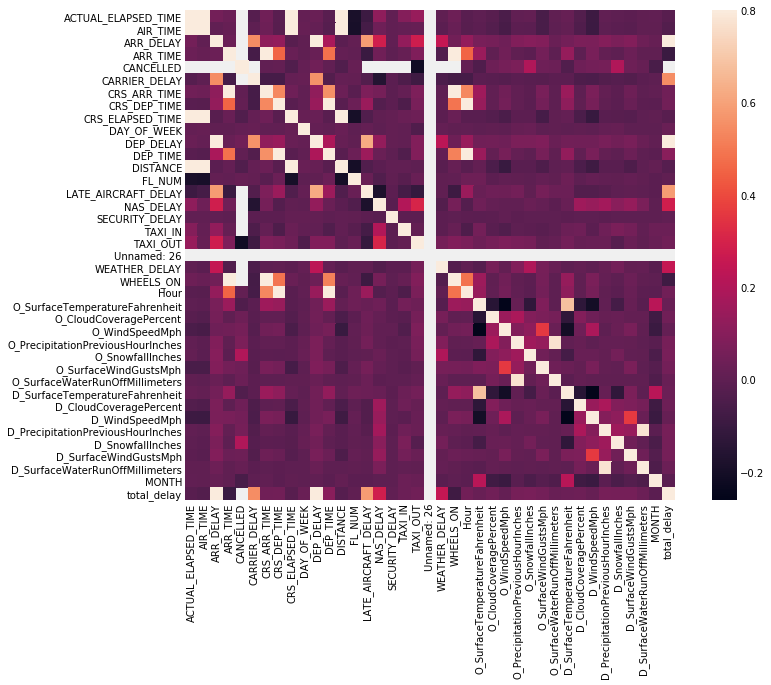

In [13]:
corrmat = flights_with_weather_df_2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

In [14]:
flights_with_weather_df_2.head(1)

,ACTUAL_ELAPSED_TIME,AIR_TIME,ARR_DELAY,ARR_TIME,CANCELLATION_CODE,CANCELLED,CARRIER_DELAY,CRS_ARR_TIME,CRS_DEP_TIME,CRS_ELAPSED_TIME,DAY_OF_WEEK,DEP_DELAY,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,LATE_AIRCRAFT_DELAY,NAS_DELAY,ORIGIN,SECURITY_DELAY,TAXI_IN,TAXI_OUT,UNIQUE_CARRIER,Unnamed: 26,WEATHER_DELAY,WHEELS_ON,Hour,O_SurfaceTemperatureFahrenheit,O_CloudCoveragePercent,O_WindSpeedMph,O_PrecipitationPreviousHourInches,O_SnowfallInches,O_SurfaceWindGustsMph,O_SurfaceWaterRunOffMillimeters,D_SurfaceTemperatureFahrenheit,D_CloudCoveragePercent,D_WindSpeedMph,D_PrecipitationPreviousHourInches,D_SnowfallInches,D_SurfaceWindGustsMph,D_SurfaceWaterRunOffMillimeters,MONTH,total_delay
0,315.0,284.0,-18.0,1737.0,NaN,0.0,NaN,1755,920,335.0,5,2.0,922.0,JFK,2586.0,2016-01-01,22,NaN,NaN,SFO,NaN,10.0,21.0,VX,NaN,NaN,1727.0,9,38.2,0.0,9.1,0.0,0.0,23.8,0.001,39.0,100.0,12.2,0.0,0.0,24.5,NaN,1,NaN


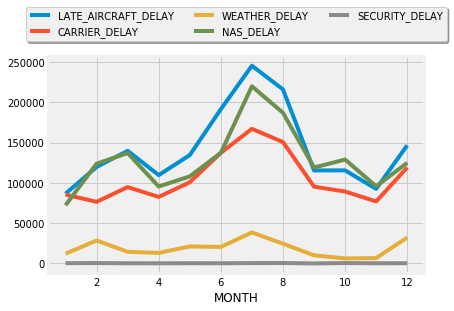

In [15]:
month_plot = flights_with_weather_df_2.groupby('MONTH')['LATE_AIRCRAFT_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY'].sum().plot()
month_plot.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
plt.show()

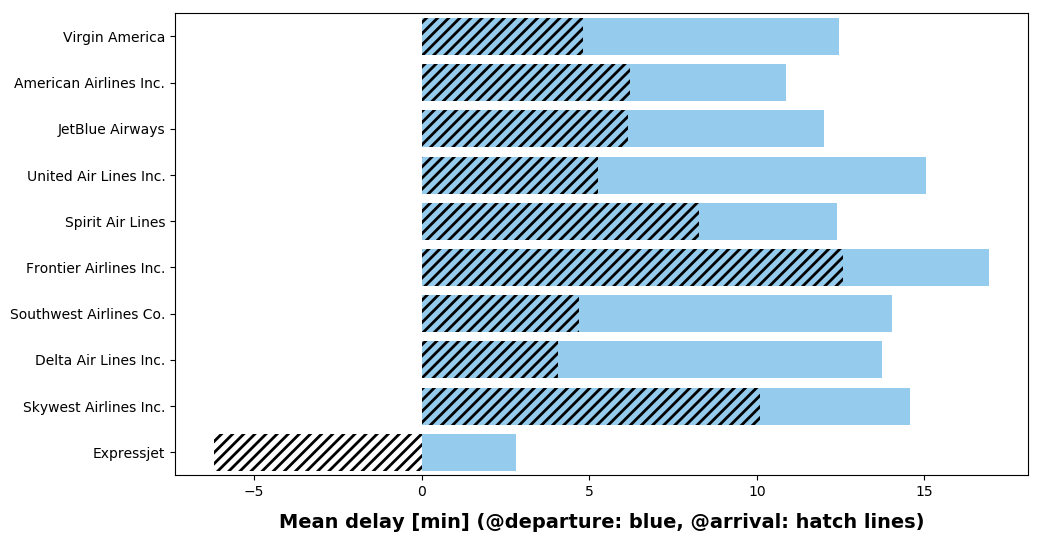

In [16]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEP_DELAY", y="UNIQUE_CARRIER", data=flights_with_weather_df_2, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARR_DELAY", y="UNIQUE_CARRIER", data=flights_with_weather_df_2, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

In [17]:
df3 = flights_with_weather_df_2

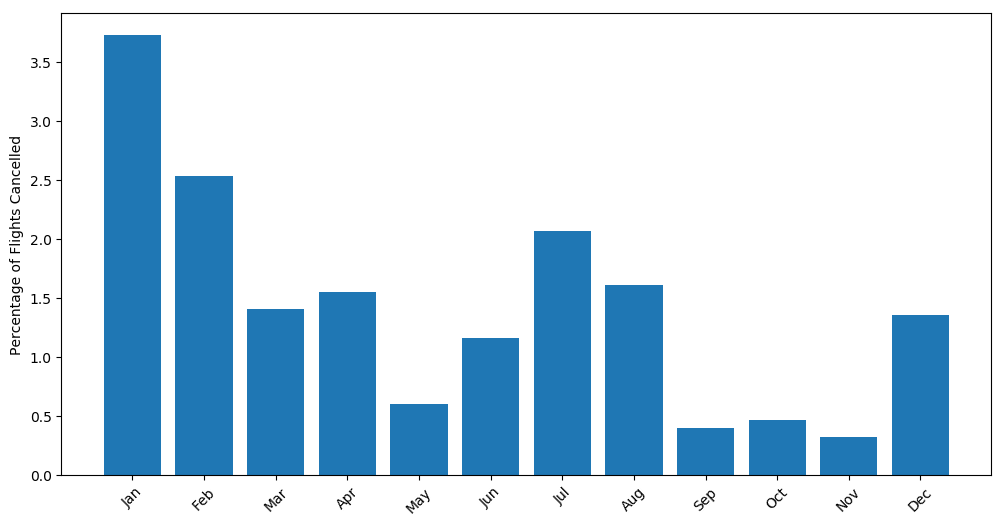

In [18]:
days_cancelled = cancelled.groupby(['MONTH']).count()
cancelled_days = days_cancelled['CANCELLED']
days_total = df3['CANCELLED'].groupby(df3['MONTH']).count()
days_frac = np.divide(cancelled_days, days_total)
x=days_frac.index.values

month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(x,days_frac*100, align='center')
ax.set_ylabel('Percentage of Flights Cancelled')
ax.set_xticks(x)
ax.set_xticklabels(month, rotation = 45)

plt.show()

In [19]:
temp = df3['O_SurfaceTemperatureFahrenheit'].groupby(df3['MONTH']).mean()
carrier_flights = df3['MONTH'].groupby(df3['MONTH']).count()
carrier_cancelled = df3['CANCELLED'].groupby(df3['MONTH']).sum()
carrier_pct_cancelled = 100*np.divide(carrier_cancelled, carrier_flights)

Months = pd.Series(['Jan','Feb','Mar','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
summary_table_carrier = pd.concat([temp,carrier_cancelled,carrier_pct_cancelled,carrier_flights], axis=1)

In [20]:
summary_table_carrier

,O_SurfaceTemperatureFahrenheit,CANCELLED,CANCELLED,MONTH
MONTH,,,,
1,36.303952,950.0,3.732076,25455
2,42.009970,612.0,2.538155,24112
3,49.234277,383.0,1.408451,27193
4,54.037433,419.0,1.550761,27019
5,61.855754,176.0,0.601154,29277
6,72.432703,347.0,1.165094,29783
7,77.931824,633.0,2.072692,30540
8,76.506630,505.0,1.613625,31296
9,71.471833,115.0,0.398627,28849


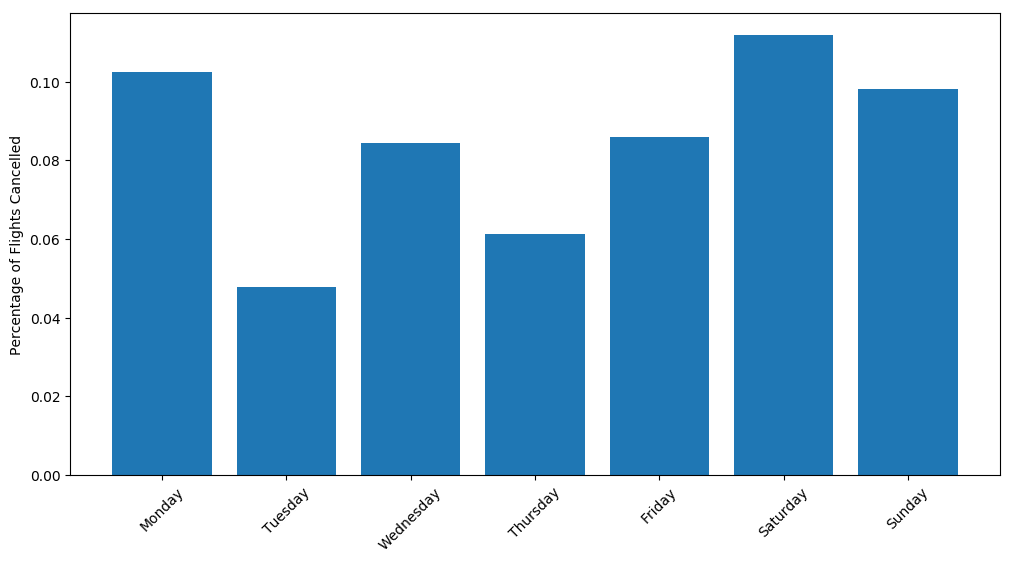

In [21]:
days_cancelled = cancelled.groupby(['DAY_OF_WEEK']).count()
cancelled_days = days_cancelled['CANCELLED']
days_total = df['CANCELLED'].groupby(df['DAY_OF_WEEK']).count()
days_frac = np.divide(cancelled_days, days_total)
x=days_frac.index.values

week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(x,days_frac*100, align='center')
ax.set_ylabel('Percentage of Flights Cancelled')
ax.set_xticks(x)
ax.set_xticklabels(week, rotation = 45)

plt.show()

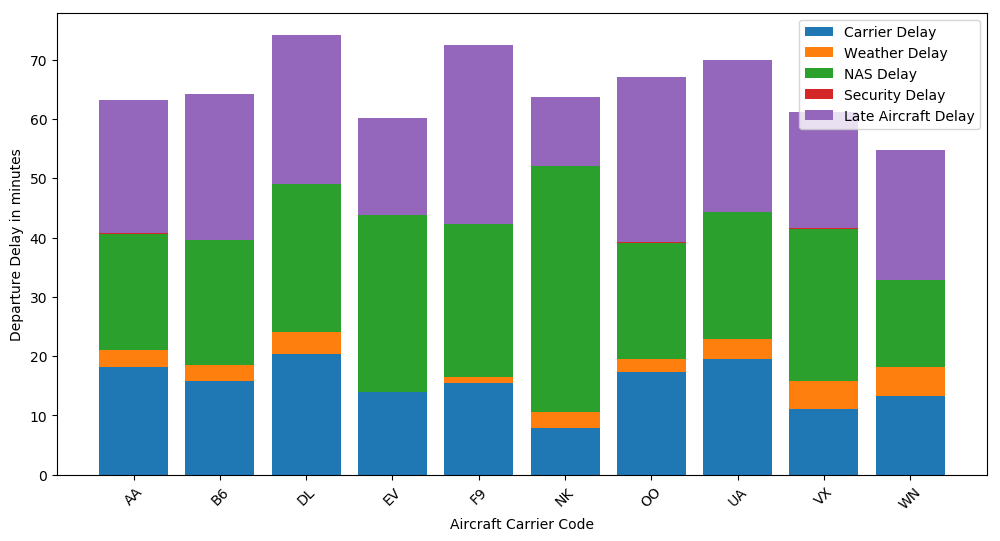

In [22]:
df3['total_delay'] = (df3['CARRIER_DELAY'] + df3['WEATHER_DELAY']
             + df3['NAS_DELAY'] + df3['SECURITY_DELAY'] + df3['LATE_AIRCRAFT_DELAY'])

df_delayed = df3[~np.isnan(df3['total_delay'])]
df3['total_delay'].fillna(0, inplace=True)
df_delayed.head()

carrier_group = df_delayed['CARRIER_DELAY'].groupby(df_delayed['UNIQUE_CARRIER']).mean()
weather_group = df_delayed['WEATHER_DELAY'].groupby(df_delayed['UNIQUE_CARRIER']).mean()
nas_group = df_delayed['NAS_DELAY'].groupby(df_delayed['UNIQUE_CARRIER']).mean()
security_group = df_delayed['SECURITY_DELAY'].groupby(df_delayed['UNIQUE_CARRIER']).mean()
late_group = df_delayed['LATE_AIRCRAFT_DELAY'].groupby(df_delayed['UNIQUE_CARRIER']).mean()

w_bottom = carrier_group.values
n_bottom = w_bottom + weather_group.values
s_bottom = n_bottom + nas_group.values
l_bottom = s_bottom + security_group.values

x = carrier_group.index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),carrier_group.values, align='center', label='Carrier Delay')
ax.bar(np.arange(len(x)),weather_group.values, align='center', bottom=w_bottom, label='Weather Delay')
ax.bar(np.arange(len(x)),nas_group.values, align='center', bottom=n_bottom, label='NAS Delay')
ax.bar(np.arange(len(x)),security_group.values, align='center', bottom=s_bottom, label='Security Delay')
ax.bar(np.arange(len(x)),late_group.values, align='center', bottom=l_bottom, label='Late Aircraft Delay')

ax.set_xlabel('Aircraft Carrier Code')
ax.set_ylabel('Departure Delay in minutes')

plt.legend()
plt.show()

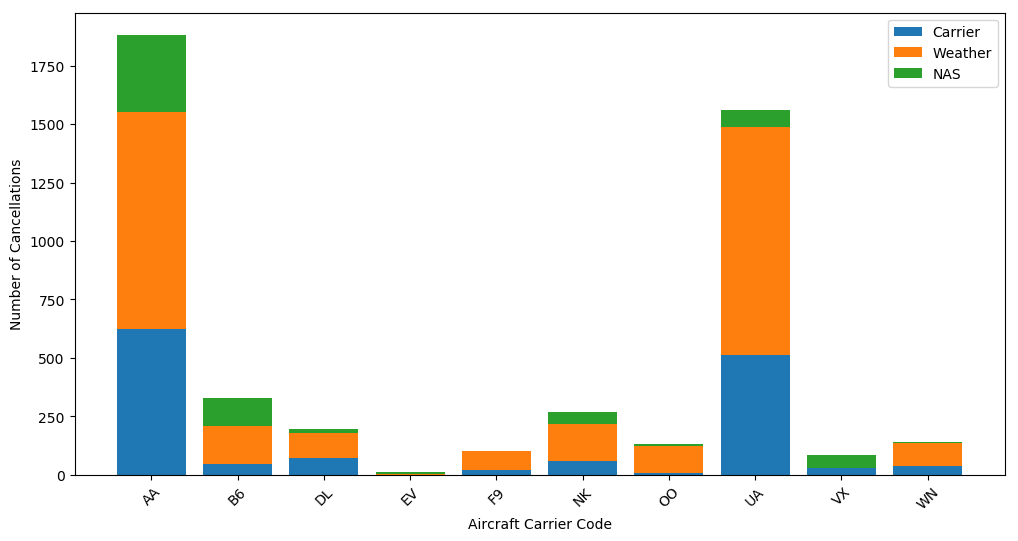

In [23]:
cancelled_group = cancelled.groupby(['UNIQUE_CARRIER','CANCELLATION_CODE']).size().reindex(fill_value=0.0).unstack()
cg = cancelled_group.fillna(0)

b_bottom = cg.loc[:,'A'].values
c_bottom = b_bottom + cg.loc[:,'B'].values
d_bottom = c_bottom + cg.loc[:,'B'].values

x = cg.loc[:,'A'].index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),cg.loc[:,'A'].values, align='center', label='Carrier')
ax.bar(np.arange(len(x)),cg.loc[:,'B'].values, align='center', bottom=b_bottom, label='Weather')
ax.bar(np.arange(len(x)),cg.loc[:,'C'].values, align='center', bottom=c_bottom, label='NAS')
#ax.bar(np.arange(len(x)),cancelled_group.loc[:,'D'].values, align='center', bottom=d_bottom, label='Security')

ax.set_xlabel('Aircraft Carrier Code')
ax.set_ylabel('Number of Cancellations')

plt.legend()
plt.show()

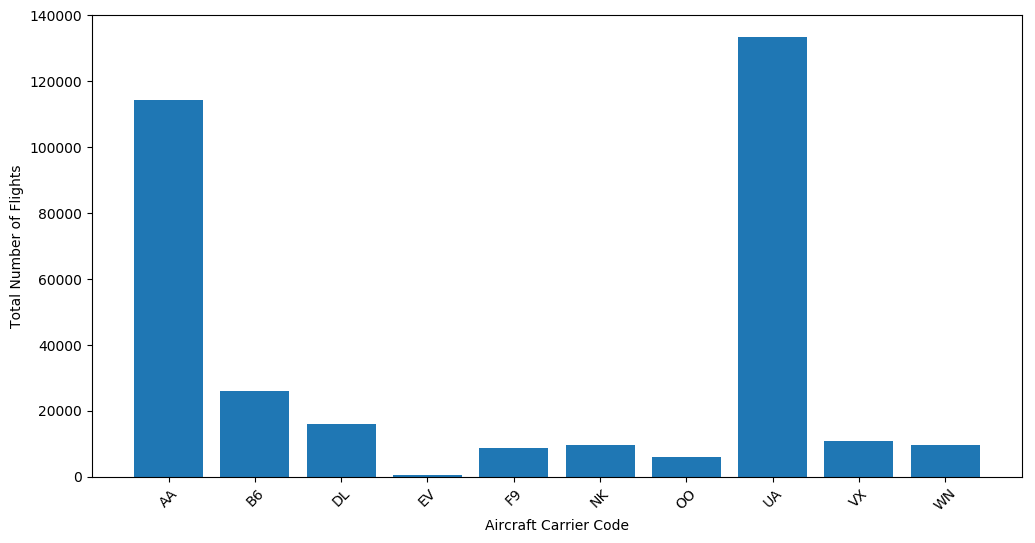

In [24]:
total_flights_per_carrier = df3['UNIQUE_CARRIER'].groupby(df3['UNIQUE_CARRIER']).count()

fig, ax1 = plt.subplots(figsize = (12,6))

x = total_flights_per_carrier.index.values

ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x, rotation = 45)
ax1.bar(np.arange(len(x)),total_flights_per_carrier.values, align='center')

ax1.set_xlabel('Aircraft Carrier Code')
ax1.set_ylabel('Total Number of Flights')

plt.show()

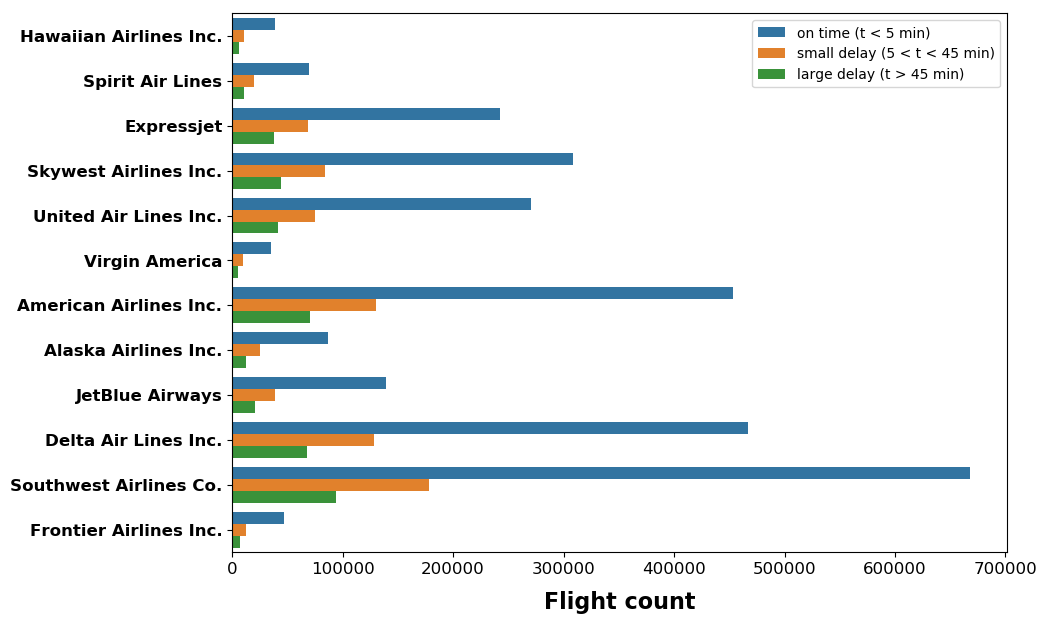

In [25]:
df_new = df3.loc[:, ['UNIQUE_CARRIER', 'DEP_DELAY']]
df_new['UNIQUE_CARRIER'] = df_new['UNIQUE_CARRIER'].replace(abbr_companies)

delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df3['DEP_DELAY'].apply(delay_type)

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

global_stats = df3['DEP_DELAY'].groupby(df3['UNIQUE_CARRIER']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="UNIQUE_CARRIER", hue='DELAY_LEVEL', data=df)

labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [26]:
carrier_flights = df3['UNIQUE_CARRIER'].groupby(df3['UNIQUE_CARRIER']).count()
carrier_cancelled = df3['CANCELLED'].groupby(df3['UNIQUE_CARRIER']).sum()
carrier_delayed = df_delayed['UNIQUE_CARRIER'].groupby(df_delayed['UNIQUE_CARRIER']).count()
#carrier_diverted = df['Diverted'].groupby(df['UNIQUE_CARRIER']).sum()
carrier_avg_time = df3['AIR_TIME'].groupby(df3['UNIQUE_CARRIER']).mean()
carrier_avg_dist = df3['DISTANCE'].groupby(df3['UNIQUE_CARRIER']).mean()
carrier_avg_delay = df3['DEP_DELAY'].groupby(df3['UNIQUE_CARRIER']).mean()
carrier_avg_taxiIn = df3['TAXI_IN'].groupby(df3['UNIQUE_CARRIER']).mean()
carrier_avg_taxiOut = df3['TAXI_OUT'].groupby(df3['UNIQUE_CARRIER']).mean()
#carrier_avg_temp = df3['O_SurfaceTemperatureFahrenheit'].groupby(df3['UNIQUE_CARRIER']).mean()
carrier_pct_cancelled = 100*np.divide(carrier_cancelled, carrier_flights)


carrier_names = pd.Series(['Virgin America Inc.','American Airlines Inc.','Jetblue Airways Corporation','United Airlines','Spirit Airlines','Frontier Airlines, Inc.','Southwest Airlines Co.','Delta Air Lines, Inc.','SkyWest Airlines','ExpressJet Airlines, Inc.'], index=carrier_flights.index)
# carrier_names = pd.Series(['Pinnacle Airlines', 'American Airlines', 'Alaska Airlines', 'Jetblue Airways',
#                       'Cobaltair', 'Delta Air Lines', 'ExpressJet Airlines', 'Frontier Airlines', 'AirTran Airways',
#                       'Hawaiian Airlines', 'Envoy Air', 'Northwest Airlines', 'US Airways Express', 
#                       'SkyWest Airlines', 'United Airlines', 'US Airways', 'Southwest Airlines',
#                       'JetSuiteX Air', 'Mesa Airlines'], index=carrier_flights.index)

summary_table_carrier = pd.concat([carrier_names, carrier_flights, carrier_cancelled, carrier_pct_cancelled, 
                                   #carrier_diverted, 
                           carrier_avg_time, carrier_avg_dist, carrier_avg_delay,
                          carrier_avg_taxiIn, carrier_avg_taxiOut], axis=1)

summary_table_carrier.columns = ['Carrier Name', 'Total Flights', 'Cancelled Flights', 'Percent Cancelled',
                          'Average Flight Time (minutes)',
                         'Average Flight Distance (miles)', 'Average Flight Delay (minutes)', 
                         'Average Taxi-In (minutes)', 'Average Taxi-Out (minutes)']



summary_table_carrier

,Carrier Name,Total Flights,Cancelled Flights,Percent Cancelled,Average Flight Time (minutes),Average Flight Distance (miles),Average Flight Delay (minutes),Average Taxi-In (minutes),Average Taxi-Out (minutes)
UNIQUE_CARRIER,,,,,,,,,
AA,Virgin America Inc.,114317,1885.0,1.648924,135.850224,986.746249,10.877897,9.906626,19.700456
B6,American Airlines Inc.,26124,327.0,1.251723,146.147695,1065.197787,12.011705,7.857176,20.280968
DL,Jetblue Airways Corporation,15996,197.0,1.231558,161.981668,1207.000625,13.740509,9.448623,24.175231
EV,United Airlines,424,12.0,2.830189,53.570388,277.478774,2.815981,8.223301,17.492925
F9,Spirit Airlines,8757,101.0,1.153363,137.389648,1033.906132,16.923334,13.210374,17.718168
NK,"Frontier Airlines, Inc.",9648,269.0,2.788143,126.379222,919.083333,12.386777,11.949451,16.515755
OO,Southwest Airlines Co.,6129,132.0,2.153696,130.912331,928.966552,14.576212,9.455531,21.597161
UA,"Delta Air Lines, Inc.",133509,1560.0,1.168461,169.370406,1303.991619,15.062687,9.200769,18.575961
VX,SkyWest Airlines,10947,83.0,0.758199,280.455314,2246.739381,12.450865,9.459591,16.822508


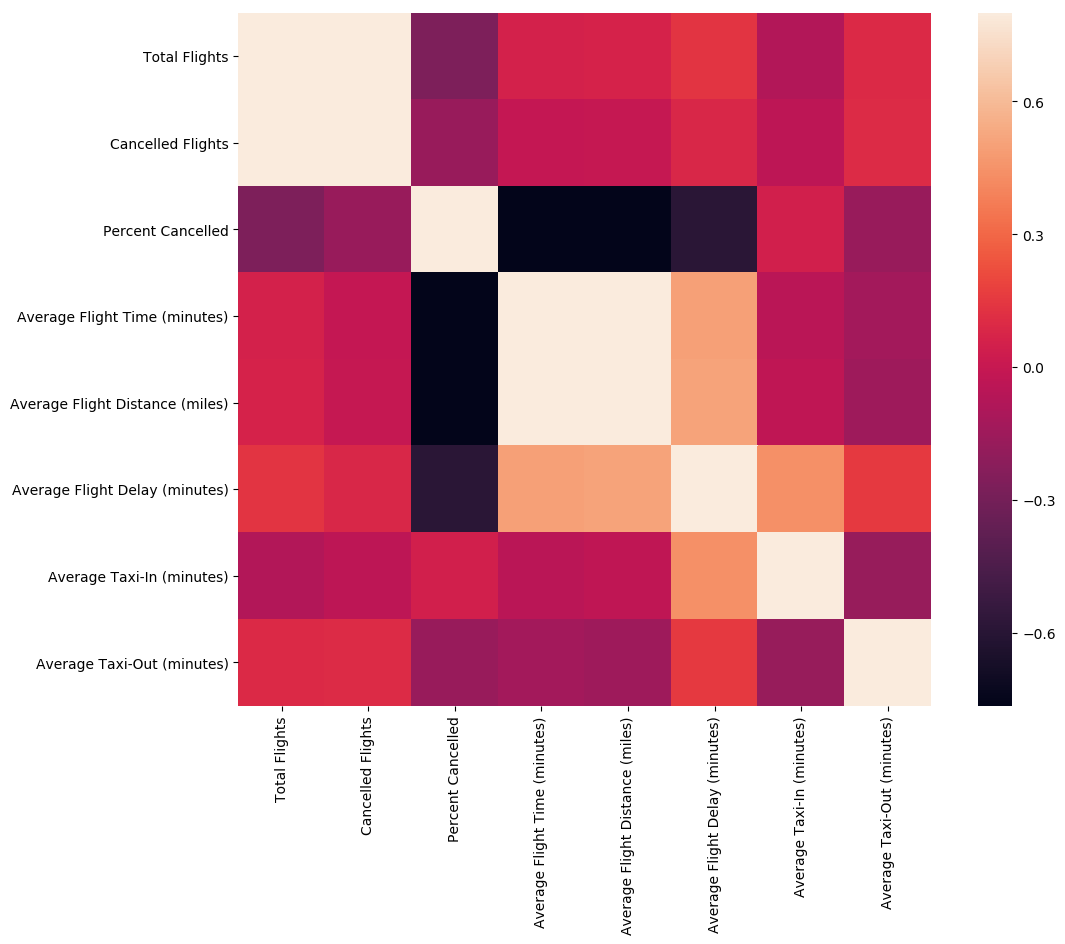

In [27]:
corrmat = summary_table_carrier.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

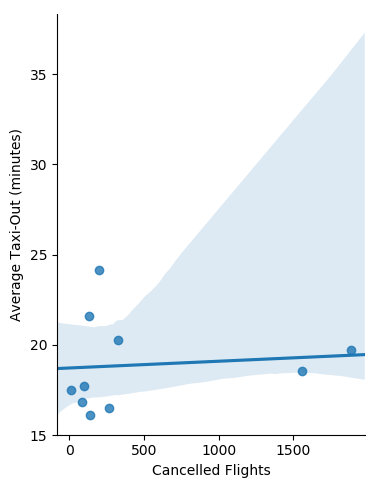

In [28]:
sns.pairplot(summary_table_carrier, y_vars=["Average Taxi-Out (minutes)"], x_vars=["Cancelled Flights"],
             size=5, aspect=.8, kind="reg");

In [29]:
origin_flights = df3['ORIGIN'].groupby(df3['ORIGIN']).count()
origin_cancelled = df3['CANCELLED'].groupby(df3['ORIGIN']).sum()
origin_delayed = df_delayed['UNIQUE_CARRIER'].groupby(df_delayed['ORIGIN']).count()
##origin_diverted = df['Diverted'].groupby(df['ORIGIN']).sum()
origin_avg_time = df3['AIR_TIME'].groupby(df3['ORIGIN']).mean()
origin_avg_dist = df3['DISTANCE'].groupby(df3['ORIGIN']).mean()
origin_avg_delay = df3['total_delay'].groupby(df3['ORIGIN']).mean()
#origin_avg_taxiIn = df['TaxiIn'].groupby(df['Origin']).mean()
origin_avg_taxiOut = df3['TAXI_OUT'].groupby(df3['ORIGIN']).mean()
orig_avg_temp = df3['O_SurfaceTemperatureFahrenheit'].groupby(df3['ORIGIN']).mean()
orig_avg_raininch = df3['O_PrecipitationPreviousHourInches'].groupby(df3['ORIGIN']).mean()
orig_avg_snowfall = df3['O_SnowfallInches'].groupby(df3['ORIGIN']).mean()


origin_pct_cancelled = 100*np.divide(origin_cancelled, origin_flights)

summary_table_origin = pd.concat([origin_flights, origin_cancelled,orig_avg_temp,orig_avg_raininch,orig_avg_snowfall, origin_pct_cancelled, 
                           origin_avg_time, origin_avg_dist, origin_avg_delay,
                           origin_avg_taxiOut], axis=1)

summary_table_origin.columns = ['Total Flights', 'Cancelled Flights','Avg Temp','orig_avg_raininch','orig_avg_snowfall', 'Percent Cancelled',
                         'Average Flight Time (minutes)',
                         'Average Flight Distance (miles)', 'Average Flight Delay (minutes)', 
                         'Average Taxi-Out (minutes)']

summary_table_origin = summary_table_origin.sort_values('Total Flights', ascending=False)
summary_table_origin.head(15)

,Total Flights,Cancelled Flights,Avg Temp,orig_avg_raininch,orig_avg_snowfall,Percent Cancelled,Average Flight Time (minutes),Average Flight Distance (miles),Average Flight Delay (minutes),Average Taxi-Out (minutes)
ORIGIN,,,,,,,,,,
ORD,54954,769.0,54.059293,0.005088,0.004979,1.399352,129.553432,953.454016,17.140281,18.662099
SFO,45784,402.0,58.645767,0.002658,0.000000,0.878036,230.454598,1987.362507,13.440700,18.352263
BOS,41510,665.0,54.418070,0.004191,0.004727,1.602024,132.018449,860.467863,11.835437,19.392773
DEN,39715,576.0,56.753030,0.002609,0.007030,1.450334,140.494031,1121.476923,14.197910,15.588317
DFW,36797,495.0,69.185336,0.005286,0.000000,1.345218,138.150410,1041.423513,14.306248,17.817295
LGA,28139,658.0,56.225065,0.005645,0.004112,2.338392,129.783429,866.012900,12.541775,24.360780
IAH,25661,302.0,72.795125,0.010759,0.000000,1.176883,144.050765,1095.638985,14.362379,17.513074
EWR,24821,364.0,56.917340,0.005693,0.003118,1.466500,193.002789,1390.854841,16.157689,19.945127
PHL,21163,273.0,57.680660,0.005198,0.003293,1.289987,144.714869,1005.613949,12.042952,20.268298


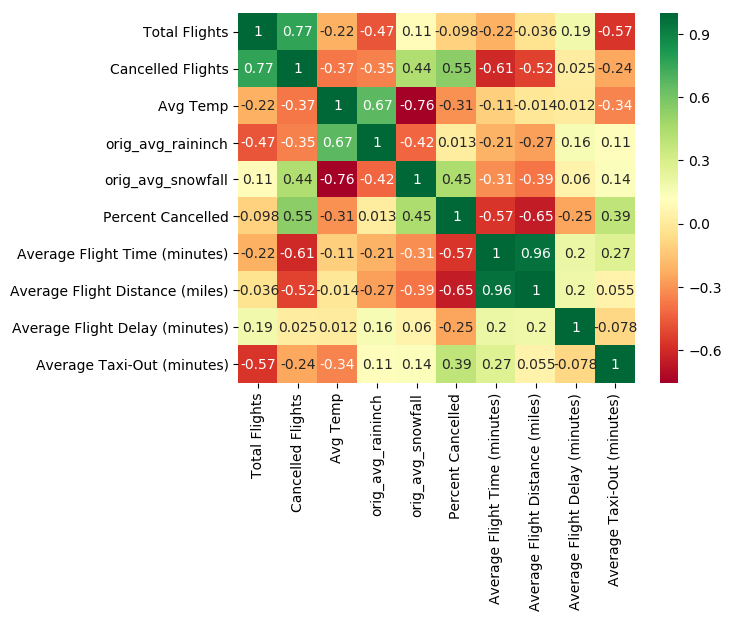

In [30]:
sns.heatmap(summary_table_origin.corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
plt.show()

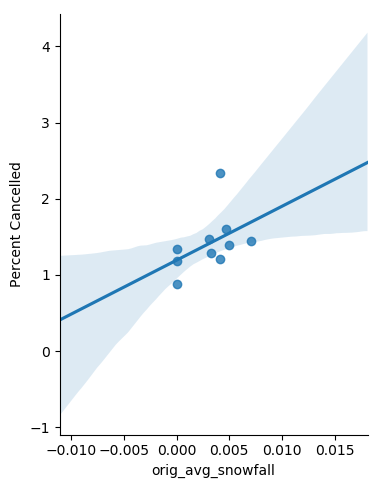

In [50]:
sns.pairplot(summary_table_origin, x_vars=['orig_avg_snowfall'], y_vars=["Percent Cancelled"],
             size=5, aspect=.8, kind="reg");

In [32]:
dest_flights = df3['DEST'].groupby(df3['DEST']).count()
dest_cancelled = df3['CANCELLED'].groupby(df3['DEST']).sum()
dest_delayed = df_delayed['UNIQUE_CARRIER'].groupby(df_delayed['DEST']).count()
dest_avg_time = df3['AIR_TIME'].groupby(df3['DEST']).mean()
dest_avg_dist = df3['DISTANCE'].groupby(df3['DEST']).mean()
dest_avg_delay = df3['total_delay'].groupby(df3['DEST']).mean()
dest_avg_taxiIn = df3['TAXI_IN'].groupby(df3['DEST']).mean()
dest_avg_temp = df3['D_SurfaceTemperatureFahrenheit'].groupby(df3['DEST']).mean()
dest_avg_raininch = df3['D_PrecipitationPreviousHourInches'].groupby(df3['DEST']).mean()
dest_avg_snowfall = df3['D_SnowfallInches'].groupby(df3['DEST']).mean()

#dest_avg_taxiOut = df['TaxiOut'].groupby(df['Dest']).mean()

dest_pct_cancelled = 100*np.divide(dest_cancelled, dest_flights)

summary_table_dest = pd.concat([dest_flights, dest_cancelled,dest_avg_temp,dest_avg_raininch,dest_avg_snowfall, dest_pct_cancelled,
                           dest_avg_time, dest_avg_dist, dest_avg_delay,
                           dest_avg_taxiIn], axis=1)

summary_table_dest.columns = ['Total Flights', 'Cancelled Flights','dest_avg_temp','dest_avg_raininch','dest_avg_snowfall', 'Percent Cancelled',
                          'Average Flight Time (minutes)',
                         'Average Flight Distance (miles)', 'Average Flight Delay (minutes)', 
                         'Average Taxi-In (minutes)']

summary_table_dest = summary_table_dest.sort_values('Total Flights', ascending=False)
summary_table_dest.head(15)

,Total Flights,Cancelled Flights,dest_avg_temp,dest_avg_raininch,dest_avg_snowfall,Percent Cancelled,Average Flight Time (minutes),Average Flight Distance (miles),Average Flight Delay (minutes),Average Taxi-In (minutes)
DEST,,,,,,,,,,
ORD,54746,765.0,53.738861,0.004755,0.004444,1.397362,130.786405,954.652943,14.172926,13.756767
SFO,45808,407.0,59.047876,0.002721,0.000000,0.888491,266.025959,1985.553571,16.641395,8.618975
BOS,41529,644.0,54.599942,0.004226,0.005059,1.550724,111.112343,859.803920,13.243709,6.811858
DEN,39160,567.0,56.259727,0.002654,0.006754,1.447906,154.844622,1123.382048,12.578677,9.309698
DFW,36887,483.0,69.120403,0.005314,0.000000,1.309404,144.873431,1045.941253,13.822675,11.205204
LGA,28121,634.0,56.655158,0.005518,0.003449,2.254543,115.776616,866.888766,15.596885,7.094042
IAH,26028,328.0,71.824001,0.010319,0.000000,1.260181,147.298863,1090.884125,12.335331,8.764177
EWR,25147,361.0,56.839404,0.005657,0.003261,1.435559,168.492310,1379.681990,16.977373,10.072239
PHL,21114,302.0,57.824936,0.005208,0.003041,1.430331,130.410103,1007.635834,11.456522,6.824587


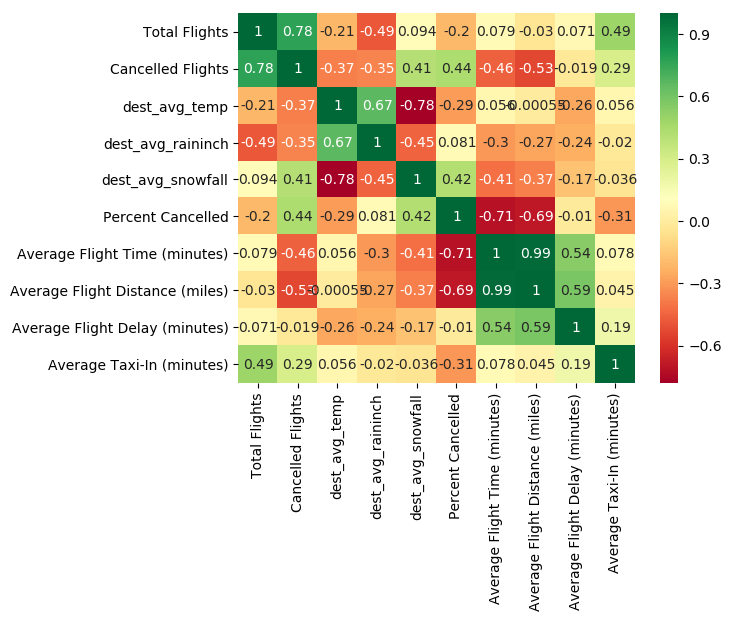

In [33]:
sns.heatmap(summary_table_dest.corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
plt.show()

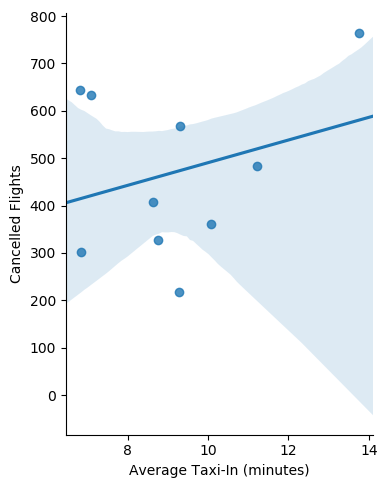

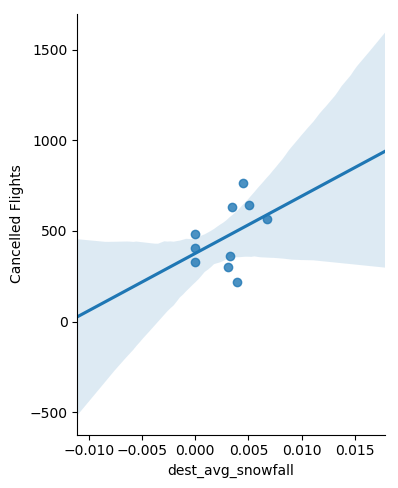

In [34]:


ax1=sns.pairplot(summary_table_dest, x_vars=['Average Taxi-In (minutes)'], y_vars=['Cancelled Flights'],
             size=5, aspect=.8, kind="reg");
ax2=sns.pairplot(summary_table_dest, x_vars=['dest_avg_snowfall'], y_vars=['Cancelled Flights'],
             size=5, aspect=.8, kind="reg");

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.show()


In [35]:
df3['Carrier mean delay'] = df3['total_delay'].groupby(df3['UNIQUE_CARRIER']).transform('mean')
df3['Carrier mean distance'] = df3['DISTANCE'].groupby(df3['UNIQUE_CARRIER']).transform('mean')
df3['Carrier cancellations'] = df3['CANCELLED'].groupby(df3['UNIQUE_CARRIER']).transform('mean')
df3['Origin cancellations'] = df3['CANCELLED'].groupby(df3['ORIGIN']).transform('mean')
df['Dest cancellations'] = df3['CANCELLED'].groupby(df3['DEST']).transform('mean')
df3['Avg_Temp_Dest'] = df3['D_SurfaceTemperatureFahrenheit'].groupby(df3['DEST']).mean()
df3['Avg_Temp_Orig'] = df3['O_SurfaceTemperatureFahrenheit'].groupby(df3['ORIGIN']).mean()
df3['Avg_Snow_Dest'] = df3['D_SnowfallInches'].groupby(df3['DEST']).mean()
df3['Avg_Snow_Orig'] = df3['O_SnowfallInches'].groupby(df3['ORIGIN']).mean()
df3['Avg_Rain_Dest'] = df3['D_PrecipitationPreviousHourInches'].groupby(df3['DEST']).mean()
df3['Avg_Rain_Orig'] = df3['O_PrecipitationPreviousHourInches'].groupby(df3['ORIGIN']).mean()




df3['Origin TaxiOut'] = df3['TAXI_OUT'].groupby(df3['ORIGIN']).transform('mean')
df3['Origin Delay'] = df3['total_delay'].groupby(df3['ORIGIN']).transform('mean')



df3['Origin'] = df3['ORIGIN'].astype('category').cat.codes
df3['Dest'] = df3['DEST'].astype('category').cat.codes
df3['CancellationCode'] = df3['CANCELLATION_CODE'].astype('category').cat.codes

df.fillna(0, inplace=True)

In [36]:
from sklearn.ensemble import RandomForestClassifier


model= RandomForestClassifier(n_estimators=100,random_state=0)
df_s = df3.sample(n=50000, random_state = 47)
X = df_s[['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'Origin', 'Dest', 'DISTANCE','D_SurfaceTemperatureFahrenheit','O_SurfaceTemperatureFahrenheit','D_SnowfallInches','O_SnowfallInches','D_PrecipitationPreviousHourInches','O_PrecipitationPreviousHourInches', 'Carrier mean distance','Origin Delay', 'Origin TaxiOut']]
Y=df_s['CANCELLED']

model.fit(X,Y)
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

D_SurfaceTemperatureFahrenheit       0.168757
O_SurfaceTemperatureFahrenheit       0.168302
CRS_DEP_TIME                         0.134724
DAY_OF_WEEK                          0.073284
MONTH                                0.060051
DISTANCE                             0.059164
D_PrecipitationPreviousHourInches    0.052430
O_PrecipitationPreviousHourInches    0.051618
Carrier mean distance                0.043305
Dest                                 0.039204
D_SnowfallInches                     0.036828
O_SnowfallInches                     0.036042
Origin TaxiOut                       0.028120
Origin Delay                         0.025176
Origin                               0.022994
dtype: float64

In [37]:
X.shape

(50000, 15)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

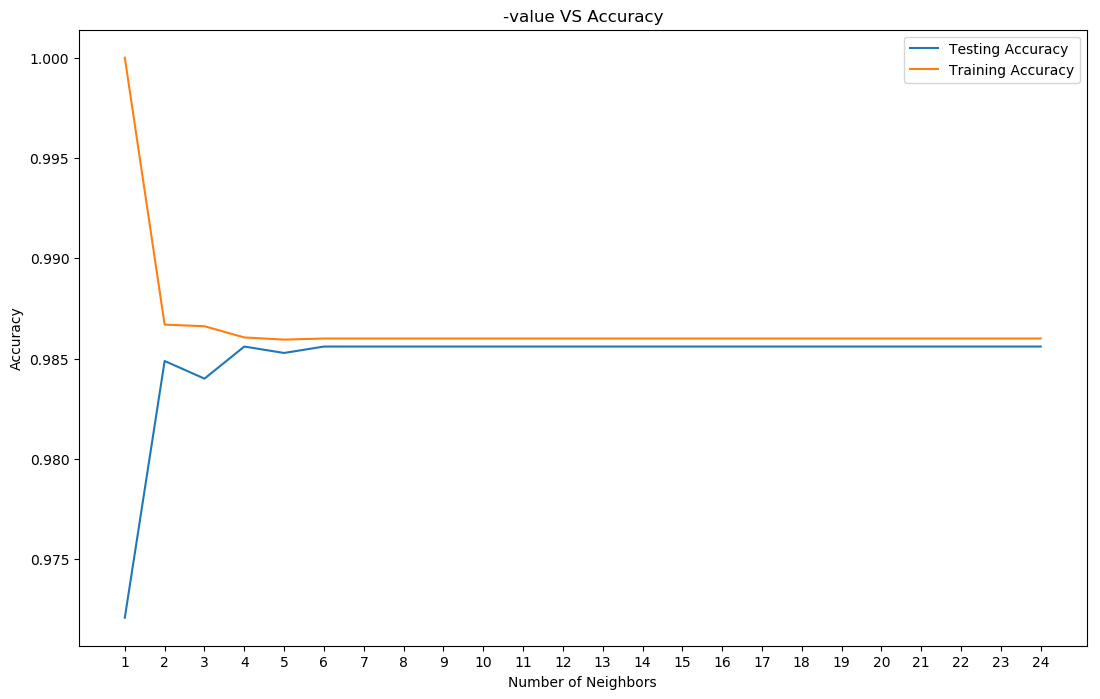

Best accuracy is 0.9856 with K = 4


In [39]:
from sklearn.neighbors import KNeighborsClassifier
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(X_train,Y_train)
    #train accuracy
    train_accuracy.append(knn.score(X_train, Y_train))
    # test accuracy
    test_accuracy.append(knn.score(X_test, Y_test))

# Plot
plt.figure(figsize=[13,8])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

In [ ]:
####### too long##########

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

svm = SVC(kernel='rbf', C=1000, gamma=6, random_state=47).fit(X_train_scaled, Y_train)
Y_pred = svm.predict(X_test_scaled)

print('Recall: {:.3f}'.format(recall_score(Y_test, Y_pred)))
print('Precision: {:.3f}'.format(precision_score(Y_test, Y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(Y_test, Y_pred)))
print('F1: {:.3f}'.format(f1_score(Y_test, Y_pred)))
confusion = confusion_matrix(Y_test, Y_pred)
print(confusion)

Y_scores = svm.decision_function(X_test_scaled)
Y_score_list = list(zip(Y_test[0:20], Y_scores[0:20]))

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

clf = RandomForestClassifier(n_estimators=50, random_state=47).fit(X_train, Y_train)

# sum(y_test)
# clf.score(X_test, y_test)

Y_predicted = clf.predict(X_test)
confusion = confusion_matrix(Y_test, Y_predicted)
#confusion
#sum(y_predicted)

print('Recall: {:.3f}'.format(recall_score(Y_test, Y_predicted)))
print('Precision: {:.3f}'.format(precision_score(Y_test, Y_predicted)))
print('Accuracy: {:.3f}'.format(accuracy_score(Y_test, Y_predicted)))
print('F1: {:.3f}'.format(f1_score(Y_test, Y_predicted)))
confusion = confusion_matrix(Y_test, Y_predicted)
print(confusion)
print('Feature importances: {}'.format(clf.feature_importances_))

Recall: 0.100
Precision: 0.857
Accuracy: 0.987
F1: 0.179
[[12317     3]
 [  162    18]]
Feature importances: [ 0.0585244   0.07587118  0.12883533  0.02165595  0.0417212   0.05615905
  0.16182082  0.16767736  0.03891505  0.04260308  0.0482441   0.06353433
  0.0416825   0.02520159  0.02755405]


In [41]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=300, learning_rate = 0.003, 
                                 max_depth = 2, random_state=37).fit(X_train, Y_train)

Y_predicted = clf.predict(X_test)
confusion = confusion_matrix(Y_test, Y_predicted)

print('Recall: {:.3f}'.format(recall_score(Y_test, Y_predicted)))
print('Precision: {:.3f}'.format(precision_score(Y_test, Y_predicted)))
print('Accuracy: {:.3f}'.format(accuracy_score(Y_test, Y_predicted)))
print('F1: {:.3f}'.format(f1_score(Y_test, Y_predicted)))
confusion = confusion_matrix(Y_test, Y_predicted)
print(confusion)
print('Feature importances: {}'.format(clf.feature_importances_))

Recall: 0.044
Precision: 0.727
Accuracy: 0.986
F1: 0.084
[[12317     3]
 [  172     8]]
Feature importances: [ 0.05276039  0.          0.          0.          0.          0.          0.
  0.04408287  0.33715964  0.56599709  0.          0.          0.          0.
  0.        ]


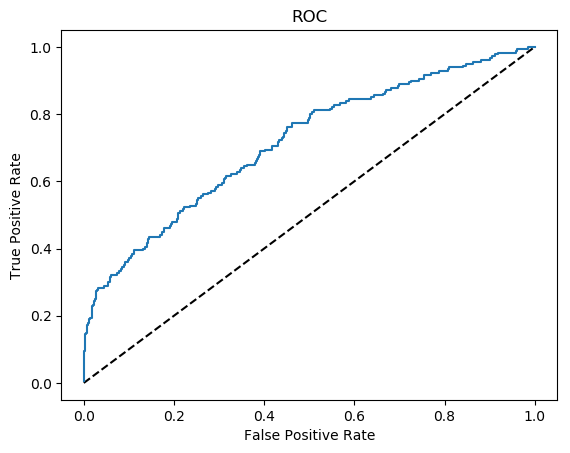

In [42]:
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [43]:
flight = df3[['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'Origin', 'Dest', 'DISTANCE','D_SurfaceTemperatureFahrenheit','O_SurfaceTemperatureFahrenheit','D_SnowfallInches','O_SnowfallInches','D_PrecipitationPreviousHourInches','O_PrecipitationPreviousHourInches', 'Carrier mean distance','Origin Delay', 'Origin TaxiOut']]
cancelled=df3['CANCELLED']

In [44]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [45]:
train,test=train_test_split(flight,test_size=0.25,random_state=0,stratify=df3['CANCELLED'])# stratify the outcome
train_X=flight
test_X=flight
train_Y=df3['CANCELLED']
test_Y=df3['CANCELLED']

In [ ]:
types=['rbf','linear']
for i in types:
    model=svm.SVC(kernel=i)
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    print('Accuracy for SVM kernel=',i,'is',metrics.accuracy_score(prediction,test_Y))

In [46]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
confusion = confusion_matrix(Y_test, Y_predicted)
print(confusion)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction,test_Y))

[[12317     3]
 [  172     8]]
The accuracy of the Logistic Regression is 0.986448046372


In [47]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
confusion = confusion_matrix(Y_test, Y_predicted)
print(confusion)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction,test_Y))

[[12317     3]
 [  172     8]]
The accuracy of the Decision Tree is 0.999994036544


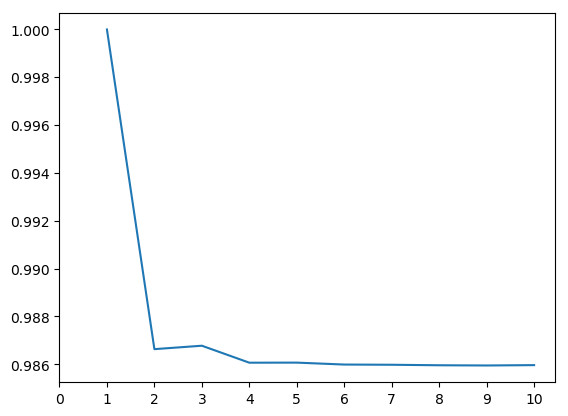

Accuracies for different values of n are: [ 0.99999404  0.98662993  0.98677305  0.9860634   0.98606639  0.98598588
  0.98597693  0.98595606  0.98594712  0.98596202]
[[12317     3]
 [  172     8]]


In [48]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
plt.show()
print('Accuracies for different values of n are:',a.values)
confusion = confusion_matrix(Y_test, Y_predicted)
print(confusion)

In [ ]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
kfold = KFold(n_splits=10, random_state=22)
xyz=[]
accuracy=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier()]
for i in models:
    model = i
    cv_result = cross_val_score(model,flight,cancelled, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame(abc,index=classifiers)   
new_models_dataframe2.columns=['CV Mean']    
new_models_dataframe2

In [49]:
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

nnclf = clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 5), random_state=47)

nnclf.fit(X_train_scaled, Y_train)
Y_predicted = nnclf.predict(X_test_scaled)
print('Recall: {:.3f}'.format(recall_score(Y_test, Y_predicted)))
print('Precision: {:.3f}'.format(precision_score(Y_test, Y_predicted)))
print('Accuracy: {:.3f}'.format(accuracy_score(Y_test, Y_predicted)))
print('F1: {:.3f}'.format(f1_score(Y_test, Y_predicted)))

Recall: 0.072
Precision: 0.650
Accuracy: 0.986
F1: 0.130
